<a href="https://colab.research.google.com/github/Nataliia5722/AI/blob/main/Transfer_learning_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is Transfer Learning?
- Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task (domain adaptation).

- Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task.

- Transfer learning only works in deep learning if the model features learned from the first task are general.

### When to Use Transfer Learning?

- Higher start. The initial skill (before refining the model) on the source model is higher than it otherwise would be.
- Higher slope. The rate of improvement of skill during training of the source model is steeper than it otherwise would be.
- Higher asymptote. The converged skill of the trained model is better than it otherwise would be.

In deep learning, transfer learning is most beneficial when we cannot obtain a huge dataset to train our network on. In some cases, we may not be able to get our hands on a big enough dataset. For such situations, using a pre-trained network is the best approach. A pre-trained network has already learned many important intermediate features from a larger dataset. Therefore, we can use that network on our small dataset.

[Transfer Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)

### [VGG16](https://arxiv.org/pdf/1409.1556v6.pdf)
  
  Simplicity and depth. In 2014, VGG models achieved great results in the ILSVRC challenge (The ImageNet Large Scale Visual Recognition Challenge). The 16 layer model achieved 92.6% top-5 classification accuracy on the test set. Similarly, the 19 layer model was able to achieve 92.7% top-5 accuracy on the test set. A 19 layer CNN  used 3x3 filters with stride and pad of 1, along with 2x2 maxpooling layers with stride 2.


  *ImageNet contains more than 14 million images covering almost 22000 categories of images. It has held the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) for years so that deep learning researchers and practitioners can use the huge dataset to come up with novel and sophisticated neural network architectures by using the images for training the networks.*

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [3]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu



### Downloading and Preparing the Dataset

VGG network takes an input image of size 224×224 by default. So, it is best to resize the CIFAR10 images as well.

In [4]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Downloading the VGG16 Network

In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet.to(device)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


### Freezing Convolution Weights

The classifier VGG16 model is classifying 1000 classes. But we need to classify the images into 10 classes only. So, we will change that. Also, we will freeze all the weights of the convolutional blocks. The model as already learned many features from the ImageNet dataset. So, freezing the Conv2d() weights will make the model to use all those pre-trained weights. This is the part that really justifies the term transfer learning.

In [6]:
# change the number of classes 
alexnet.classifier[6].out_features = 10
# freeze convolution weights
for param in alexnet.features.parameters():
    param.requires_grad = False

### Optimizer and Loss Function

In [7]:
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

### Training and Validation Functions

In [8]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [9]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [11]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(1):
    train_epoch_loss, train_epoch_accuracy = fit(alexnet, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(alexnet, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0248, Train Acc: 71.99
46.622226591904955 minutes


### Visualizing the Plots

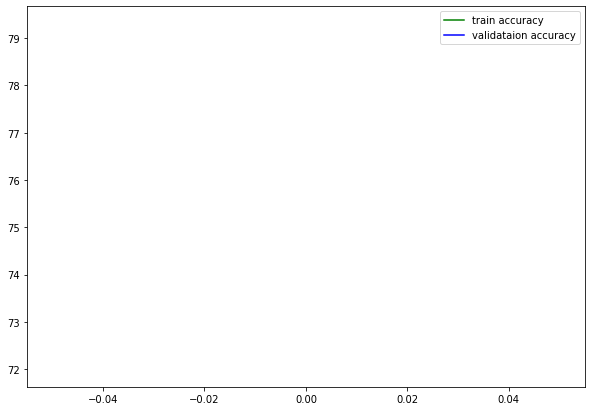

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

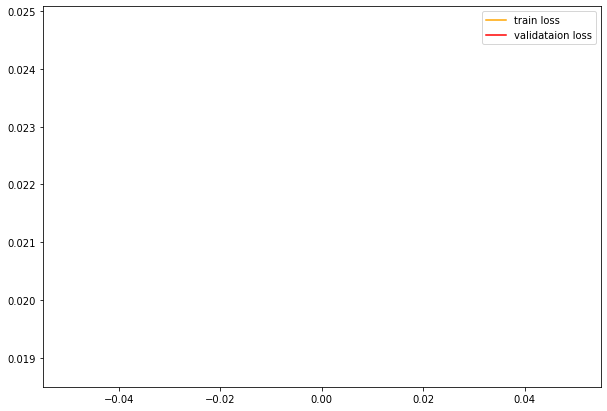

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [14]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for int, data in enumerate(testloader):
    inputs_test, labels_test = data
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    outputs = alexnet(inputs_test)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels_test).squeeze()
    for i in range(4):
        label = labels_test[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))  

Accuracy of airplane : 77 %
Accuracy of automobile : 93 %
Accuracy of  bird : 76 %
Accuracy of   cat : 55 %
Accuracy of  deer : 65 %
Accuracy of   dog : 80 %
Accuracy of  frog : 89 %
Accuracy of horse : 93 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %
